1. Import thư viện


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


2025-10-17 17:58:08.871689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 17:58:10.309950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import joblib


2. Đọc & tiền xử lý dữ liệu


In [3]:
df = pd.read_csv("datatrainai_5_years_clean.csv", parse_dates=["date"])
cols = ["date","T2M","QV2M","PS","WS10M","PRECTOTCORR",
        "CLRSKY_SFC_SW_DWN","Latitude","Longitude","hour","day","month","season"]
df = df[cols].dropna()

df["location"] = df["Latitude"].astype(str) + "_" + df["Longitude"].astype(str)
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds() // 3600
df["time_idx"] = df["time_idx"].astype(int)

print("✅ Data loaded:", df.shape)

# Chọn các cột numeric để scale
features = ["T2M","QV2M","PS","WS10M","PRECTOTCORR","CLRSKY_SFC_SW_DWN","hour","day","month"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
joblib.dump(scaler, "scaler.joblib")
print("✅ Đã lưu scaler để dùng lại khi dự báo.")

✅ Data loaded: (1616057, 15)
✅ Đã lưu scaler để dùng lại khi dự báo.


3. Tạo Dataset cho TFT


In [4]:
input_len = 24 * 7   # 7 ngày quan sát
output_len = 24      # dự báo 1 ngày
cutoff = int(len(df) * 0.8)

train_df = df.iloc[:cutoff]
val_df = df.iloc[cutoff:]

def sequence_generator(data, input_len=input_len, output_len=output_len):
    arr = data[features].values.astype("float32")
    target = data["T2M"].values.astype("float32")
    for i in range(len(arr) - input_len - output_len):
        X = arr[i:i+input_len]
        y = target[i+input_len:i+input_len+output_len]
        yield X, y

train_dataset = tf.data.Dataset.from_generator(
    lambda: sequence_generator(train_df, input_len, output_len),
    output_signature=(
        tf.TensorSpec(shape=(input_len, len(features)), dtype=tf.float32),
        tf.TensorSpec(shape=(output_len,), dtype=tf.float32)
    )
).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: sequence_generator(val_df, input_len, output_len),
    output_signature=(
        tf.TensorSpec(shape=(input_len, len(features)), dtype=tf.float32),
        tf.TensorSpec(shape=(output_len,), dtype=tf.float32)
    )
).batch(64).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset generators ready!")

✅ Dataset generators ready!


2025-10-17 17:58:18.958717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-17 17:58:18.959030: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4. Khởi tạo mô hình TFT


In [5]:
def build_hybrid_cnn_lstm(input_shape, output_len):
    inputs = keras.Input(shape=input_shape)
    
    # --- CNN trích đặc trưng cục bộ ---
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="causal")(inputs)
    x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="causal")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # --- LSTM học quan hệ dài hạn ---
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    
    # --- Fully Connected ---
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_len)(x)
    
    return keras.Model(inputs, outputs)

model = build_hybrid_cnn_lstm((input_len, len(features)), output_len)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 168, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 168, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 84, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,280 (688.59 KB)

 Trainable params: 176,280 (688.59 KB)

 Non-trainable params: 0 (0.00 B)

5. Huấn luyện mô hình


In [6]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    ]
)

Epoch 1/20
    155/Unknown 23s 125ms/step - loss: 0.1550 - mae: 0.3032

KeyboardInterrupt: 

In [1]:
from tensorflow.python.platform import build_info as tf_build_info
print("CUDA version:", tf_build_info.build_info['cuda_version'])
print("cuDNN version:", tf_build_info.build_info['cudnn_version'])


2025-10-18 14:35:57.331685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 14:35:58.584967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


CUDA version: 12.3
cuDNN version: 8


In [ ]:
from tensorflow.python.platform import build_info as tf_build_info
print("CUDA version:", tf_build_info.build_info['cuda_version'])
print("cuDNN version:", tf_build_info.build_info['cudnn_version'])


CUDA version: 12.5.1
cuDNN version: 9


Lưu lại mô hình đã huấn luyện


In [ ]:
model.save("tft_weather_vietnam_tf.keras")
print("🎉 Huấn luyện hoàn tất và đã lưu mô hình TensorFlow!")

🎉 Huấn luyện hoàn tất và đã lưu mô hình TensorFlow!


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


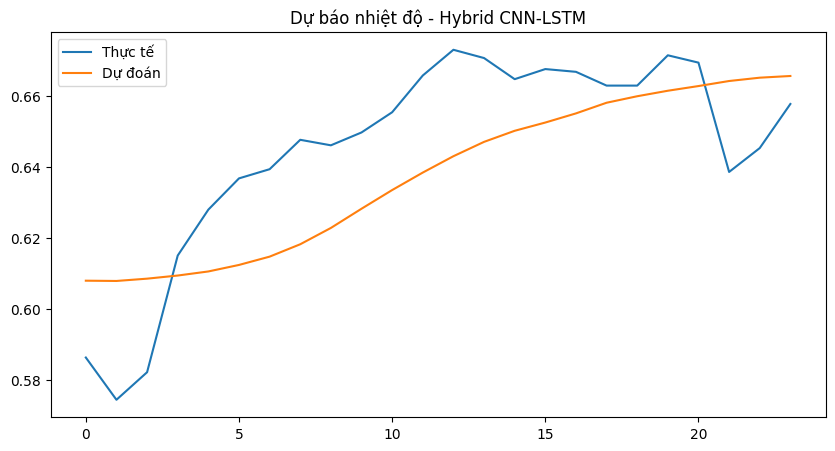

In [ ]:
for X_batch, y_batch in val_dataset.take(1):
    y_pred = model.predict(X_batch)
    plt.figure(figsize=(10,5))
    plt.plot(y_batch[0], label="Thực tế")
    plt.plot(y_pred[0], label="Dự đoán")
    plt.legend()
    plt.title("Dự báo nhiệt độ - Hybrid CNN-LSTM")
    plt.show()